# Progetto DL24: YesWeKAN - Analisi, confronto e interpretabilità

⭐ Nel notebook **Introduzione KAN** abbiamo spiegato nel dettaglio le idee alla base del nostro progetto, le motivazioni che hanno guidato la nostra scelta e abbiamo introdotto l'argomento con un aporoccio divulgativo e volto alla comprensione dell'argomento da parte di chi si affacci per la prima volta alla scoperta delle reti KAN.

Con questo notebook ci proponiamo invece di presentare il cuore del nostro lavoro che parte dalle operazioni di preprocessing e trattamento dei dati nel dataset e arriva alla trasparenza algoritmica passando per la definizione delle architetture d'interesse per il lavoro e il loro confronto prima in termini prestazionali e poi sotto l'aspetto dell'equità algoritmica.

Tutti i modelli presentati in questo notebook sono stati definiti e ottimizzati mediante delle operazioni di tuning eseguite e descritte nel notebook **Tuning degli iperparametri**

### Importazione librerie

📚 Come operazione preliminare importiamo le **librerie** che saranno utilizzate in questo notebook, per chiarezza le abbiamo divise in gruppi:

- Librerie di **sistema**: intriducono funzionalità a basso-medio livello.
- Librerie per l'utilizzo di **Matrici, dataframe e tensori**.
- Librerie per l'utilizzo di **Modelli di Machine Learning e Deep Learning**.
- Librerie per la **trasparenza algoritmica**.
- Librerie **grafiche**: introducono funzioni per la stampa di tabelle, grafici e strumenti di visualizzazione dei risultati.
- Librerie **custom**: Introducono i livelli DenseKAN e di funzioni di utilità.

⚠️ Per rendere l'esperimento ripetibile, andiamo anche ad **impostare il seme casuale** di tutte le librerie che fanno utilizzo della casualità nell'elaborazione, in modo che queste vadano a **generare gli stessi valori** sequenzialmente ad ogni riavvio del notebook (o meglio, del kernel Python che esegue il notebook). 

Ci teniamo a far notare che in questo modo, nel caso si esegua più volte la stessa cella, essa probabilmente non presenterà gli stessi risultati, andando a **compromettere la riproducibilità** di tutte le celle di codice a seguire. Per riportare il flusso di esecuzione ad uno stato di riproducibilità sarà necessario **riavviare il kernel** Python del notebook. 

La scelta di impostare il seed e non ogni volta il random state è dovuta al fatto che per alcune librerie risultava difficoltoso se non impossibile impostare ogni random state, oltre ad un fattore di comodità maggiore ed un fattore di rischio minore nella scrittura del codice. Il _seed_ viene impostato prima di importare le librerie custom del progetto poiché fare il contrario non garantiva la riproducibilità.

In [28]:
# Librerie di sistema
import os
import random
import base64
import datetime

# Array, dataframe e tensori
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Modelli ML & DL
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tensorflow.keras.layers import Dense, Dropout

# Trasparenza algoritmica
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer

# Librerie grafiche
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
import matplotlib.pyplot as plt # fornisce funzioni per generare grafici
import seaborn as sns
import networkx as nx # fornisce funzioni per la creazione di grafi

# Impostazione dei semi casuali
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Librerie custom
import utility as ut
from tfkan import DenseKAN

# Dataset

## Scelta del dataset

💱 Visto che il **cambio radicale** nell'architettura avviene al **livello degli archi** tra input e output, è possibile ridefinire tutti i principali tipi di architettura visti durante il corso: non solo i livelli densamente connessi, ma anche convolutivi, ricorrenti, e perfino transformer. Tuttavia in questo progetto, dovendo implementare autonomamente questo nuovo tipo di rete, abbiamo optato per usare dei **livelli densamente connessi**.

🩺 Per la scelta del dataset, abbiamo pensato di non focalizzarci sulle possibili applicazioni citate nel paper, ma di approfondire qualche altro settore. Vista la maggiore spiegabilità delle reti KAN rispetto ad una rete MLP, abbiamo scelto un dataset in **campo medico**, in cui la spiegabilità e la trasperanza algoritmica sono fattori determinanti non solo per il personale medico, che ha -anche- il compito di valutare le decisioni della rete, ma anche per i pazienti, in modo che possano prendere coscienza dei motivi dietro le scelte mediche.

🏥 Il dataset che abbiamo scelto, dopo aver guardato le opzioni disponibili su [Kaggle](https://www.kaggle.com/), è [Hospital Length of Stay Dataset Microsoft](https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft). Qui il task è di **regressione**, e consiste nello stimare i giorni di ricovero di un paziente, conoscendo diversi dati personali e medici di quest'ultimo.

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [29]:
# Variabili del dataset
DATASET_NAME = 'LengthOfStay'

# Nomi feature accorciati (per migliorare la visualizzazione nei grafici)
FEATURES = [ 
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

# Numero feature usate dal modello
N_FEATURES = len(FEATURES) 

# Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

# Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

## Analisi del dataset

🔎 Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record.

Per farlo utilizziamo la classe `FeatureStatisticsGenerator` che produce un risultato in formato HTML dunque visualizzabile sul notebook.

In [30]:
# Genera statistiche sul dataset
fsg = FeatureStatisticsGenerator()
dataframes = [ {'table': df, 'name': DATASET_NAME}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

# Impostazioni per la visualizzazione
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

# Mostra analisi grafica
display(HTML(html)) 

c:\Users\matte\documents\KAN1\Lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


### Osservazioni
- Non sono presenti **dati mancanti**

- Alcuni attributi come *vdate* e *discharged* seguono una **distribuzione uniforme**

- Alcuni attributi come *hematocrit*, *sodium*, *glucose*, *creatinine*, *bmi*, *pulse* seguono una distribuzione approssimativamente **normale**
- Alcuni attributi come *rcount*, *respiration*, *bloodureanitro* sono sbilanciati, cioè presentano una distribuzione marcatamente **asimmetrica**
- Alcuni attributi come *pneum*, *irondef*, *asthma*, *gender* e altri sono **binari**
- L'attributo **gender**, che sarà al centro delle nostre valutazioni sull'equità algoritmica, è leggermente sbilanciato infatti circa il 58% delle istanze sono riferite a donne e solo il 42% a uomini
- L'attributo target *lengthofstay* presenta uno sbilanciamento verso valori bassi infatti, sebbene presenti valori tra 1 e 17, ha una media di 4 e una mediana equivalente.

Complessivamente possiamo dunque affermare che i dati raccolti sono di buona qualità, considerando anche che lo sbilanciamento di diversi attributi la cui distribuzione risulta asimmetrica è dovuto alla presenza di **outliers**.

Consapevoli del fatto che lo sbilanciamento dell'attributo target potrebbe causare scarsa variabilità nelle predizioni, durante il confronto dei modelli ci impegnamo a valitare anche la metrica **R² score**.

## Pre-processing del dataset

🔢 Importando il dataset e visualizzando i record ci accorgiamo che sono presenti degli attributi categorici come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow, infatti ricordiamo che le reti, essendo funzioni differenziabili, possono trattare esclusivamente tensori numerici. Dobbiamo dunque codificare tutti i valori in forma rigorosamente numerica.

Gli attributi che devono essere ricodificati sono:

- **eid**: è un identificativo univoco del record nel dataset; non porta alcuna informazione, per cui non lo consideriamo.
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare la data di fine ricovero, in quanto non è un'informazione che ci dovrebbe essere nota al momento della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

In [31]:
# Rimuove la colonna "discharged"
df.drop("discharged", axis=1, inplace=True) 

# Rimuove la colonna "eid"
df.drop("eid", axis=1, inplace=True)

# Codifica del 5+ in 5 in rcount
keys = sorted(df["rcount"].unique())
values = range(len(keys))
df.replace({"rcount": dict(zip(keys, values))}, inplace=True)

# Codifica delle date come numeri interi progressivi
keys = df["vdate"].unique()
values = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in keys]
df.replace({"vdate": dict(zip(keys, values))}, inplace=True)

# Codifica del genere come intero binario
keys = df["gender"].unique()
values = range(len(keys))
df.replace({"gender": dict(zip(keys, values))}, inplace=True)

# Codifica dei facid come numeri interi progressivi
keys = df["facid"].unique()
values = range(len(keys))
df.replace({"facid": dict(zip(keys, values))}, inplace=True)

Come si può osservare, le reti neurali mostrano migliori prestazioni quando i tensori da esse elaborati contengono valori tra 0 e 1, dunque è opportuno standardizzare i dati.
Eseguiamo quindi una **normalizzazione MinMax**, che porterà tutti i valori nell'intervallo $[0, 1]$ e per farlo utilizzeremo la funzione `standardize`, definita nella nostra libreria custom.

In [32]:
# Standardizzazione degli attributi del dataset
df = df.astype(float)
df.iloc[:, :-1] = ut.standardize(df.iloc[:, :-1])

## Separazione del dataset

A questo punto il dataset ha solamente valori numerici. Separiamo il dataset dividendolo in training set, validation set e test set. Abbiamo anche valutato l'utilizzo del metodo di K-Fold, ma dato che si tratta di una tecnica per la validazione del modello, che poi andrebbe riaddestrato su tutto il training set, abbiamo abbandonato la strada per via dell'eccessivo tempo di addestramento totale.

🚫 Abbiamo anche provato a non riistanziare il modello tra un fold e l'altro, rendendoci però conto che le metriche che restituiva erano falsate, a causa del fatto che ad un cambio di fold parte del set che usava come training diventa il validation set del fold successivo. Abbiamo quindi optato per una divisione classica in training, validation e test set.

Dopo esserci salvati in alcuni file csv le partizioni del dataset separate, convertiamo il dataframe in un tensore Tensorflow.

In [33]:
# Definizione rapporto di split
TEST_RATIO = 0.20
VAL_RATIO = 0.20

# Separazione train, validation, test
def train_val_test_split(df: pd.DataFrame, test_ratio: float, val_ratio: float | None) -> tuple[pd.DataFrame]:
    val_ratio = val_ratio or 0
    x_train_val, x_test, y_train_val, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_ratio*len(df)/len(x_train_val))
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(df, TEST_RATIO, VAL_RATIO)

# Creazione dei dataset di train, validation, test in csv
x_train.to_csv("datasets/x_train.csv", index=False)
y_train.to_csv("datasets/y_train.csv", index=False)
x_val.to_csv("datasets/x_val.csv", index=False)
y_val.to_csv("datasets/y_val.csv", index=False)
x_test.to_csv("datasets/x_test.csv", index=False)
y_test.to_csv("datasets/y_test.csv", index=False)

# Conversione dei set in tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Stampa le dimensioni dei nuovi set creati
print(f"train: {x_train.shape} val: {x_val.shape} test: {x_test.shape}")

train: (60000, 25) val: (20000, 25) test: (20000, 25)


🔧 Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte, dalle reti fully connected agli algoritmi più tradizionali. Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Come misure di errore utilizzeremo le metriche tipiche di un task di regressione cioè **MAE**, **MSE** e **RMSE**. Introdurremo inoltre il Coefficiente di determinazione $R^2$ definito come $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} = 1 - \frac{SSR}{SST}$$ in cui 

- $SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ (somma dei quadrati residui); quantifica la variabilità nelle predizioni del modello
- $SST = \sum_{i=1}^{n} (y_i - \bar{y}_i)^2$ (somma dei quadrati totali); quantifica la "qualità" nelle predizioni in  termini di scostamento dal valore medio, infatti un regressore che predice sistematicamente il valore medio non è buono.

Infine definiamo alcuni parametri relativi all'addestramento dei modelli che saranno utilizzati nei metodi `compile` e `fit`.

In [34]:
# Lista di metriche necessarie per valutare le performance 
METRICS_NAME = {"mean_absolute_error":"mae", "mean_squared_error":"mse", "root_mean_squared_error":"rmse", "r2_score": "r2_score"}
METRICS = [tf.keras.metrics.get(metric_name) for metric_name in METRICS_NAME]
for metric in METRICS:
    metric.name = METRICS_NAME[metric.name]

# Costanti dei modelli
BATCH_SIZE = 128
EPOCHS = 300
LOSS = "mae"

# Lista dei modelli addestrati e delle loro performance
elenco_modelli = {}
histories = {}

🏋️ Definiamo adesso una funzione ausiliaria per l'**addestramento** di un modello. Questa definisce le funzioni di callback che vengono utilizzate in fase di addestramento del modello, implementa l'addestramento stesso, e restituisce lo storico delle prestazioni per ogni epoca.

💾 Abbiamo inserito una sola funzione di callback, ovvero la **`ModelCheckpoint`**, che confronta una metrica (in questo caso la validation loss) dell'ultimo modello con quella del modello migliore fino a quel momento, e nel caso riconosca una miglior performance salva questo modello. Abbiamo pensato di inserire anche la callback di `EarlyStopping`, ma abbiamo valutato che ai fini del progetto potesse essere interessante vedere l'andamento delle metriche dei modelli anche **durante una fase di overfitting**. Alla fine dell'addestramento viene ricaricato il modello migliore per il confronto prestazionale.

Per quanto riguarda l'addestramento dei modelli di machine learning tradizionale, abbiamo scritto la funzione `trainingML` che semplicemente esegue l'addestramento del modello.

In [35]:
# Funzione per l'addestramento dei modelli DL
def training(model, epochs=EPOCHS, batch_size=BATCH_SIZE) -> dict:
    # 
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_loss',
            verbose=1,
            save_best_only=True
        )
    ]
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)
    model.load_weights("best_model.keras")
    return history.history

# Funzione per l'addestramento dei modelli DL
def trainingML(model):
    model.fit(x_train, y_train)

# Definizione modelli

## KAN

📜 Come spiegato nell'articolo su cui ci basiamo e ribadito nel notebook **Introduzione KAN**, ogni livello $l$ di una rete KAN contiene $inputs_l*units_l$ funzioni spline, ognuna delle quali ha formula $$\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i}$$

Il numero totale dei parametri del livello si ottiene sommando:
- I coefficienti $w_s$, uno per ogni spline; totale = $inputs_l$ * $units_l$
- I coefficienti $c_i$, uno per ogni funzione basis, il cui numero per ogni spline è uguale a $grid\_size - spline\_order - 1$; totale = $inputs_l$ * $units_l$ * $\#B_i$
- I bias $w_b$, uno per ogni spline; totale = $inputs_l$ * $units_l$

Il **numereo totale di parametri** sara quindi: $inputs_l * units_l * (1 + grid\_size - spline\_order)$

Nonostante il conteggio dei parametri sia maggiore rispetto a quello di una rete MLP, vedremo che nella maggior parte dei casi ne serviranno molti meno per raggiungere se non superare le prestazioni di quest'ultima.

Definiamo e addestriamo adesso una rete KAN. I suoi iperparametri derivano dal tuning, che approfondiamo nel notebook **Tuning degli iperparametri**. La scelta di impostare l'iperparametro `grid_range=[0, 1]` deriva dalla standardizzazione dei dati, che infatti sono compresi in tale intervallo.

In [36]:
# Creazione del modello KAN con parametri del tuning
kan = tf.keras.models.Sequential([
    DenseKAN(16, grid_range=[0, 1], grid_size=25),
    DenseKAN(4, grid_range=[-10, 10], grid_size=32),
    DenseKAN(6, grid_range=[-7, 7], grid_size=12),
    DenseKAN(1, grid_range=[-10, 10], grid_size=24)
])

# Build del modello (chiamata necessaria a definire la dimensione dell'input quando si utilizza l'API Sequential)
kan.build(input_shape=(None, N_FEATURES))
kan.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.008), loss=LOSS, metrics=METRICS)

# Stampa del sommario
kan.summary()

# Training modello e salvataggio performance
histories['KAN'] = training(kan)
elenco_modelli['KAN'] = kan

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 16)             │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 4)              │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_2 (DenseKAN)          │ (None, 6)              │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_3 (DenseKAN)          │ (None, 1)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,492 (44.89 KB)

 Trainable params: 11,492 (44.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9250 - mae: 0.9250 - mse: 2.0244 - r2_score: 0.6458 - rmse: 1.3444
Epoch 1: val_loss improved from inf to 0.38274, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.9219 - mae: 0.9219 - mse: 2.0128 - r2_score: 0.6478 - rmse: 1.3404 - val_loss: 0.3827 - val_mae: 0.3827 - val_mse: 0.3241 - val_r2_score: 0.9417 - val_rmse: 0.5693
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4142 - mae: 0.4142 - mse: 0.3693 - r2_score: 0.9344 - rmse: 0.6077
Epoch 2: val_loss improved from 0.38274 to 0.33206, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.4142 - mae: 0.4142 - mse: 0.3693 - r2_score: 0.9344 - rmse: 0.6076 - val_loss: 0.3321 - val_mae: 0.3321 - val_mse: 0.2854 - val_r2_score: 0.9487 - val_rmse: 0.5342
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3642 - mae: 0.3642 - mse: 0.3198 - r2_score: 0.9432 - rmse: 0.5655
Epoch 3: val_loss 

Possiamo notare un'ottima metrica di validation loss, considerando che il numero di parametri, come vedremo, è di gran lunga inferiore rispetto alla rete MLP. Uno dei punti più critici, come è possibile notare durante l'esecuzione del codice, nonostante i meno parametri, è il tempo di addestramento notevolmente più lungo di una rete KAN rispetto a una rete MLP; questo è dovuto alla maggiore complessità delle operazioni da svolgere all'interno di un singolo arco della rete. Ricordiamo però che questo è sicuramente dovuto anche ad un'implementazione acerba e non ottimizzata del livello _DenseKAN_.

## MLP

🧠 A questo punto definiamo una classica **rete a livelli completamente connessi** MLP, utilizzata molto frequentemente nelle architetture allo stato dell'arte.

Utilizziamo delle funzioni di attivazione ReLU e Elu nei livelli intermedi mentre, trattandosi di un task di regressione, l'ultimo livello avrà una sola unità di output e nessuna funzione di attivazione. In questo caso abbiamo notato un miglioramento delle performance con l'utilizzo dell'ottmizzatore *Adam*. 

In [8]:
# Creazione del modello MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(156, activation='elu'),
    tf.keras.layers.Dense(164, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Build del modello (chiamata necessaria a definire la dimensione dell'input quando si utilizza l'API Sequential)
mlp.build(input_shape=(None, N_FEATURES))
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00075), loss=LOSS, metrics=METRICS)

# Stampa sommario
mlp.summary()

# Training modello e salvataggio performance
histories['MLP'] = training(mlp)
elenco_modelli['MLP'] = mlp

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325 (1.27 KB)

 Trainable params: 325 (1.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
434/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1118 - mae: 3.1118 - mse: 15.1456 - r2_score: -1.6808 - rmse: 3.8411
Epoch 1: val_loss improved from inf to 1.45148, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0432 - mae: 3.0432 - mse: 14.6512 - r2_score: -1.5948 - rmse: 3.7727 - val_loss: 1.4515 - val_mae: 1.4515 - val_mse: 3.3410 - val_r2_score: 0.3991 - val_rmse: 1.8278
Epoch 2/3
450/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3767 - mae: 1.3767 - mse: 3.0388 - r2_score: 0.4608 - rmse: 1.7414
Epoch 2: val_loss improved from 1.45148 to 0.95886, saving model to best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3711 - mae: 1.3711 - mse: 3.0183 - r2_score: 0.4643 - rmse: 1.7353 - val_loss: 0.9589 - val_mae: 0.9589 - val_mse: 1.6375 - val_r2_score: 0.7055 - val_rmse: 1.2796
Epoch 3/3
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8962 - mae: 0.8962 - mse: 1.5125 - r2_score: 0.7315 - rmse: 1.2293
Epoch 3: val_los

Da questa non ci aspettiamo comportamenti particolari: è un tipo di rete che abbiamo approfonditamente studiato durante il corso. Addestrando questa rete dopo la KAN diventa evidente come il tempo di addestramento sia significativamnente diverso, che però viene compensato da una validation loss a favore della KAN.

## KAN - MLP (livelli misti)

🏭 Definiamo anche un'architettura **ibrida**, un mix tra KAN e MLP con l'idea di poter combinare in un'unica rete tutti i vantaggi di queste due. Da un lato desideriamo l'accuratezza, il minor numero di parametri e la scalabilità di una KAN, dall'altra cerchiamo di ridurre i tempi di addestramento avvicinandoli a quelli comparativamente minori di un MLP.

Per quanto riguarda la spiegabilità, questa viene compromessa in maniera decisiva dalla presenza dei livelli Dense, infatti perdiamo completamente il controllo su quali valori entrano in input alle spline, e sebbene possiamo osservare la composizione delle funzioni, **non sono spiegabili le trasformazioni dei valori in ingresso**; per chiarire il concetto, sarebbe come se capissimo le operazioni che vengono fatte tra i dati, ma non sapessimo cosa quei dati rappresentano, quali elaborazioni hanno subito per arrivare alla forma che osserviamo.

Per tunare questa rete non abbiamo sfruttato del codice apposito, ma abbiamo fatto diverse prove manuali per renderla la più piccola e accurata possibile.

In [ ]:
# Creazione del modello KAN con parametri del tuning
kanmlp = tf.keras.models.Sequential([
    DenseKAN(8, grid_range=[0, 1], grid_size=25),
    Dense(16, activation='relu'),
    DenseKAN(1, grid_range=[-5, 5], grid_size=8)
])

# Build del modello (chiamata necessaria a definire la dimensione dell'input quando si utilizza l'API Sequential)
kanmlp.build(input_shape=(None, N_FEATURES))
kanmlp.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=LOSS, metrics=METRICS)



# Stampa del sommario
kanmlp.summary()

# Training modello e salvataggio performance
histories['KAN_MLP'] = training(kanmlp)
elenco_modelli['KAN_MLP'] = kanmlp

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_8 (DenseKAN)          │ (None, 16)             │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_9 (DenseKAN)          │ (None, 3)              │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_10 (DenseKAN)         │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,784 (38.22 KB)

 Trainable params: 9,784 (38.22 KB)

 Non-trainable params: 0 (0.00 B)

Fold 0
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.9553 - mae: 0.5888 - mse: 0.9674 - r2_score: 0.8268 - rmse: 0.9823 - val_loss: 0.4159 - val_mae: 0.4159 - val_mse: 0.3693 - val_r2_score: 0.9331 - val_rmse: 0.6077
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4420 - mae: 0.4420 - mse: 0.4208 - r2_score: 0.9253 - rmse: 0.6486 - val_loss: 0.3964 - val_mae: 0.3964 - val_mse: 0.3769 - val_r2_score: 0.9317 - val_rmse: 0.6139
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3676 - mae: 0.3676 - mse: 0.3612 - r2_score: 0.9359 - rmse: 0.6010 - val_loss: 0.3644 - val_mae: 0.3644 - val_mse: 0.3750 - val_r2_score: 0.9321 - val_rmse: 0.6124
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3388 - mae: 0.3388 - mse: 0.3314 - r2_score: 0.9412 - rmse: 0.5757 - val_loss: 0.3164 - val_mae: 0.3164 - val_mse: 0.3071 - val_r2_score: 0.9444 - val_rmse: 0.5541
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3255 - mae: 0.3255 - mse: 0

Addestrando la rete con livelli sia KAN sia MLP, otteniamo, come ci si aspetterebbe, un tempo inferiore alla rete KAN, ma superiore ad una rete MLP, con anche una validation loss tra le due. Come vedremo poi nel dettaglio dei confronti, questa può quindi effettivamente rappresentare un buon compromesso tra i due tipi di reti.

## Albero Decisionale di Regressione

🌲 Introduciamo ora il primo modello basato sul Machine Learning tradizionale: un **albero decisionale di regressione**. Come abbiamo fatto per le reti ad apprendimento automatico, anche in questo caso abbiamo assegnato gli iperparametri in seguito ad un tuning, e utilizeremo gli stessi in tutti gli alberi dei modelli successivi.

Uno dei motivi che ci ha spinto a optare per un albero è la possibilità di stampare a video una **rappresentazione del modello** in modo da poter visualizzare gli attributi utilizzati in fase di predizione. Essendo l'albero un modello estremamente spiegabile, conoscere gli attributi che utilizza potrebbe darci una prima indicazione su quali siano i più significativi in termini di discriminazione delle istanze. Tuttavia teniamo presente che i criteri utilizzati da un modello **non danno nessuna indicazione** su quelli utilizzati da un altro, in questo caso vogliamo soltanto avere un'idea di massima sull'importanza relativa degli attributi.

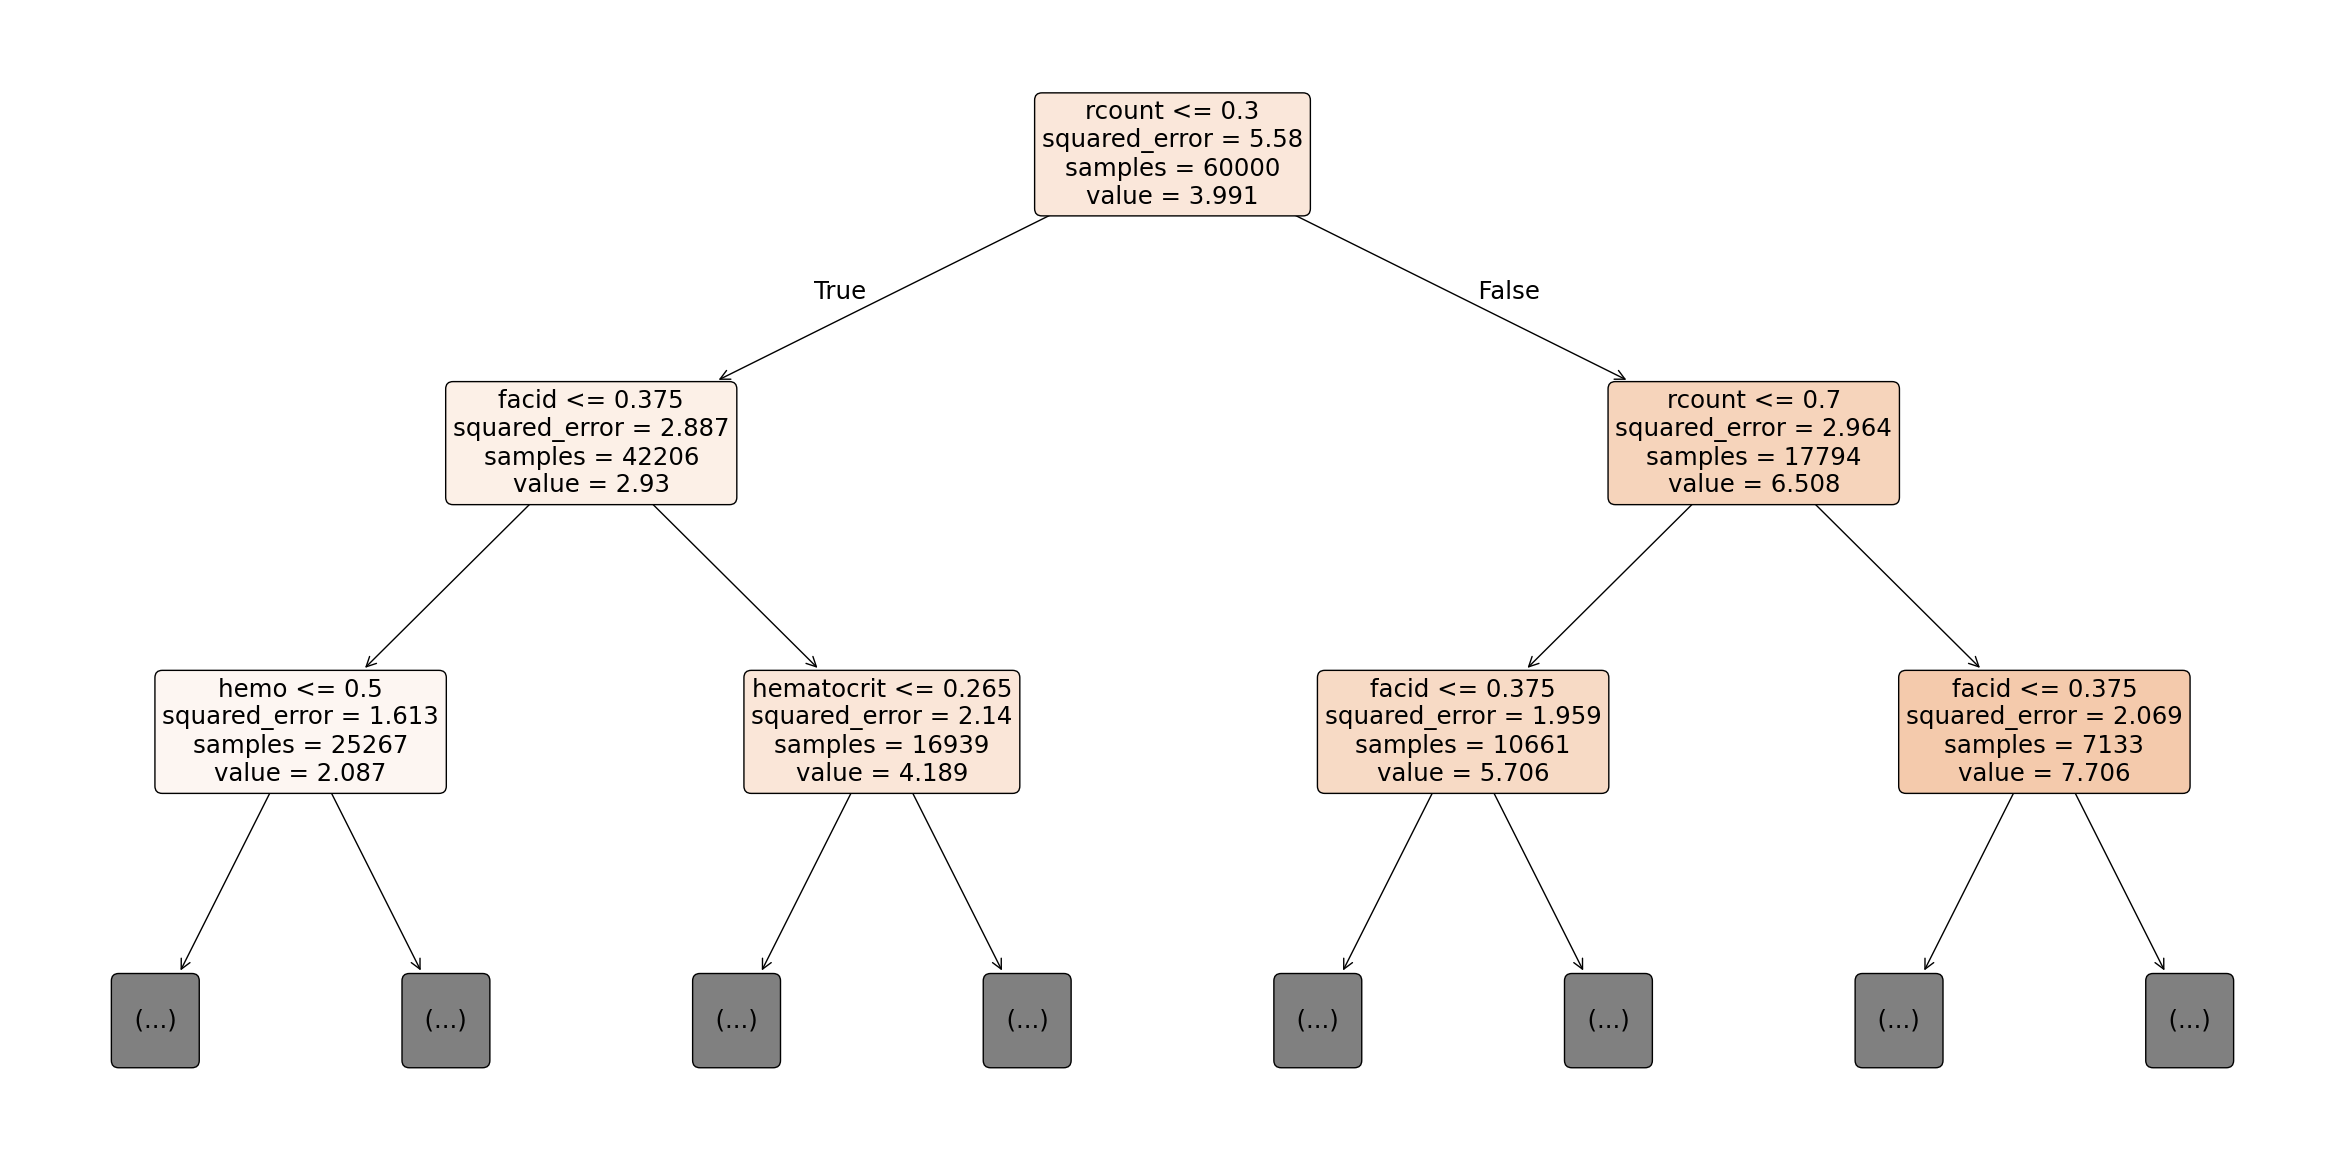

In [9]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(
    ccp_alpha=0.000000001,
    criterion='squared_error',
    max_depth=35,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=0,
    splitter='best'
)

# Addestramento
trainingML(tree)

# Aggiunge il modello alla lista modelli
elenco_modelli['TREE'] = tree

# Disegna l'albero
plt.figure(figsize=(30,15))
plot_tree(tree, max_depth=2, filled=True, rounded=True, feature_names=FEATURES)
plt.show()

🪢 In questo grafico, il colore di sfondo dei nodi ha una saturazione tanto più alta quanto maggiore è il valore medio delle istanze che arrivano a tale nodo. Notiamo che il primo attributo su cui l'albero discrimina è **rcount**, mentre il secondo è **facid**; come vedremo in seguito, l'importanza relativa di questi attributi sarà confermata.

## Random Forest 

🌳 Come secondo approccio di Machine Learning tradizionale introduciamo una **Random Forest** di regressione; rispetto all'albero ci aspettiamo prestazioni migliori ma il prezzo da pagare (come spesso accade) sarà una minore trasparenza e tempi di addestramento piu onerosi.

La foresta che utilizziamo è composta da 250 alberi con gli stessi iperparametri utilizzati per l'albero precedentemente definito.

In [ ]:
# Crea il modello della random forest
forest = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=35,
    max_features=1.0,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=250,
    random_state=0,
    verbose=0,
    warm_start=False
)

# Addestramento
trainingML(forest)

# Aggiunge il modello alla lista modelli
elenco_modelli['FOREST'] = forest

## Ensemble 

🧑‍🔧 Infine definiamo un modello di regressione **ensemble**, composto da un albero decisionale, un Linear Regressor e un regressore bayesiano.

Per questo modello abbiamo sperimentato anche delle altre configurazioni, in particolare valutando l'opportunità di introdurre un Support Vector Machine al posto del regressore lineare, ma abbiamo notato che a fronte di una seppur notevole aumento delle prestazioni intorno ai 10 punti percentuali, questo non solo aumentava notevolmente il tempo di addestramento e soprattutto il tempo di calcolo di `feature importance`, tant'è che quest'ultimo non ha mai completato la sua esecuzione.

In [25]:
# Crea il modello di ensemble
ensemble = VotingRegressor(
    estimators=[
        ('tree', DecisionTreeRegressor(
            ccp_alpha=0.000000001,
            criterion='squared_error',
            max_depth=35,
            max_features=None,
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1,
            min_samples_split=2,
            min_weight_fraction_leaf=0.0,
            random_state=0,
            splitter='best'
        )),        
        ('linear', LinearRegression(n_jobs=-1)),
        ('bayes', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, tol=0.001, verbose=False))
    ],
    n_jobs=None,
    verbose=False,
    weights=None
)

# Addestramento
trainingML(ensemble)

# Aggiunge il modello alla lista modelli
elenco_modelli['ENSEMBLE'] = ensemble

# Confronto dei modelli

## Confronto delle prestazioni

### Metriche

⏱️ A questo punto possiamo effettuare il confronto tra le **prestazioni** dei modelli appena definiti:
- Preliminarmente calcoleremo le metriche di valutazione per ognuno dei modelli
- Successivamente le rappresenteremo attraverso una **heatmap**, una visualizzazione molto efficiente che grazie ai channel **tonalità** e **saturazione** di colore facilita il confronto e mette in risalto i modelli migliori e quelli peggiori; in particolare abbiamo fatto in modo che in ciascuna heapmap le tonalità tendenti al blu indichino prestazioni migliori, mentre quelle tendenti al rosso prestazioni peggiori.

In [26]:
# Definisce i colori da usare per le barre
COLORS = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] 

# Definizione funzione per calcolo metriche di errore del modello
def calculate_metrics(model, X, y):
    # Calcolo delle previsioni del modello
    predictions = model.predict(X).reshape(-1)

    # Calcolo metriche
    result = {}
    for metric in METRICS:
        metric.reset_state()
        result[metric.name] = float(metric(y, predictions))
    return result

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


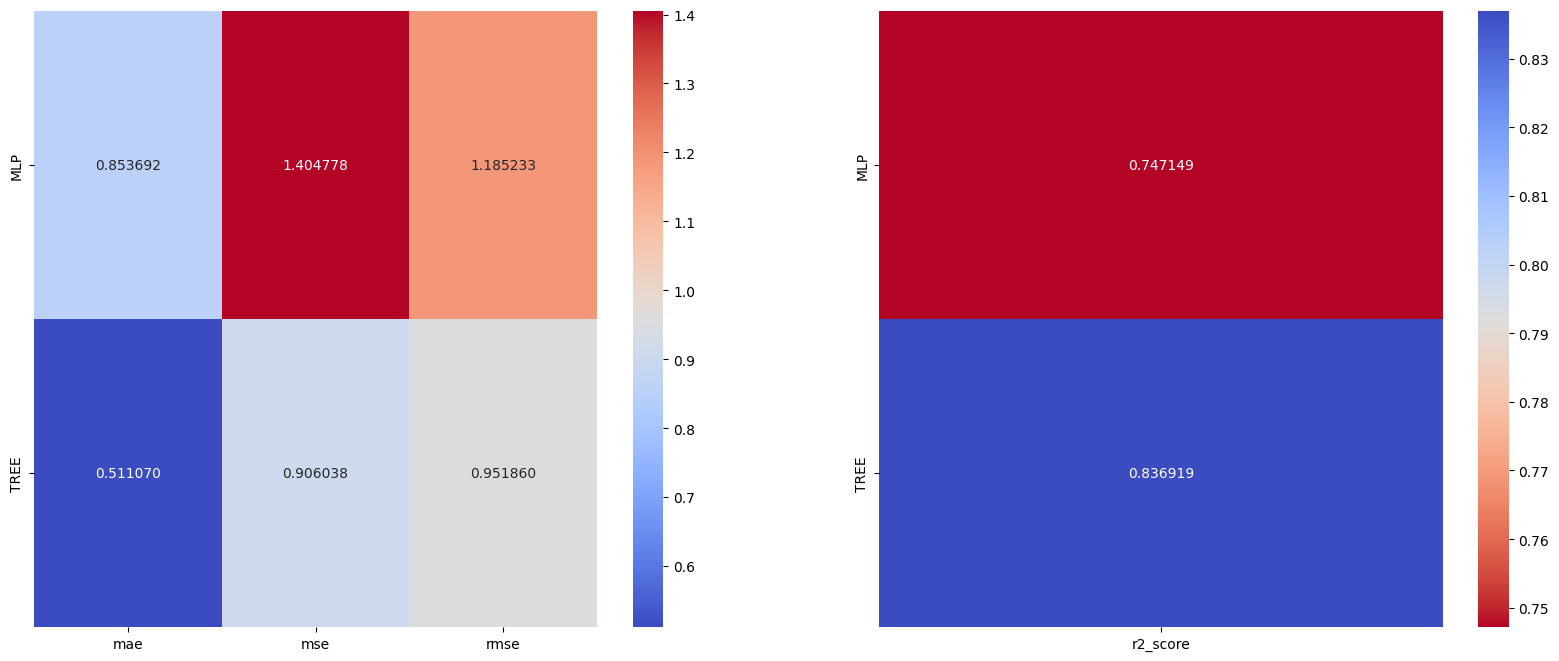

In [11]:
performance = {metric: [] for metric in list(METRICS_NAME.values()) if metric != "r2_score"}
performance_r2 = {"r2_score": []}

# Salvataggio performance di ogni modello
for model in elenco_modelli.values():
    # Calcolo delle metriche per il modello corrente
    result_metrics = calculate_metrics(model, x_test, y_test)

    # Aggiunta delle metriche al dizionario delle performance
    for name, result in list(result_metrics.items())[:-1]:
        performance[name].append(result)
    performance_r2["r2_score"].append(result_metrics["r2_score"])

# Creazione di un DataFrame con le performance dei modelli
df_error = pd.DataFrame(performance, index=elenco_modelli.keys())
df_r2 = pd.DataFrame(performance_r2, index=elenco_modelli.keys())

# Visualizzazione della heatmap
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.heatmap(df_error, annot=True, cmap='coolwarm', fmt='.6f')  
plt.subplot(1, 2, 2)
sns.heatmap(df_r2, annot=True, cmap='coolwarm_r', fmt='.6f')  
plt.show()

Si nota immediatamente come la rete KAN sia prestazionalmente superiore in tutte le metriche da noi monitorate, mentre i modelli di machine learning tradizionale sono nettamente inferiori, particolarmente il modello dell'albero decisionale e del regressore ensemble.

Confrontando i modelli, possiamo notare il minor numero di parametri usati dalla rete KAN (11.402) rispetto alla rete MLP (33.369), d'altra parte i tempi di addestramento di quest'ultima sono molto minori.

Considerando che il MAE è dimensionalmente confrontabile con il RMSE, notiamo che la prima è minore della seconda in tutti i modelli; questo indica che l'entità dell'errore è mediamente più determinante rispetto alla quantità di errori commessi.

Questo è un comportamento da noi aspettato, a causa dello sbilanciamento dell'attributo target *lenghtofstay*. Inoltre, visto il task di cui ci stiamo occupando, non costituisce un grosso problema: riteniamo che sia preferibile sapere esattamente quanti giorni starà in ospedale la maggior parte delle volte pur sapendo che raramente questo numero sarà significativamente diverso. 

### Predizioni

📐 Nella seguente cella confrontiamo i nostri modelli sulla base della loro "accuratezza" di predizione; qui con accuratezza, con un piccolo abuso di linguaggio dalla terminologia della classificazione, intendiamo il confronto tra il numero di predizioni corrette e il numero di predizioni errate dei modelli.

Trattandosi di un task di regressione si potrebbe anche introdurre un certo margine di tolleranza considerando predizioni corrette anche quelle che si discostano entro un certo range dal valore target (ad esempio, nel nostro caso, avremmo potuto considerare corrette predizioni con un giorno in più o in meno di differenza dal ground truth).
Abbiamo tuttavia preferito seguire un approccio più rigido, anche considerando la delicatezza dell'ambito di applicazione, e prendere come corrette solo le predizioni che, a seguito dell'arrotondamento, sono identiche al target.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step


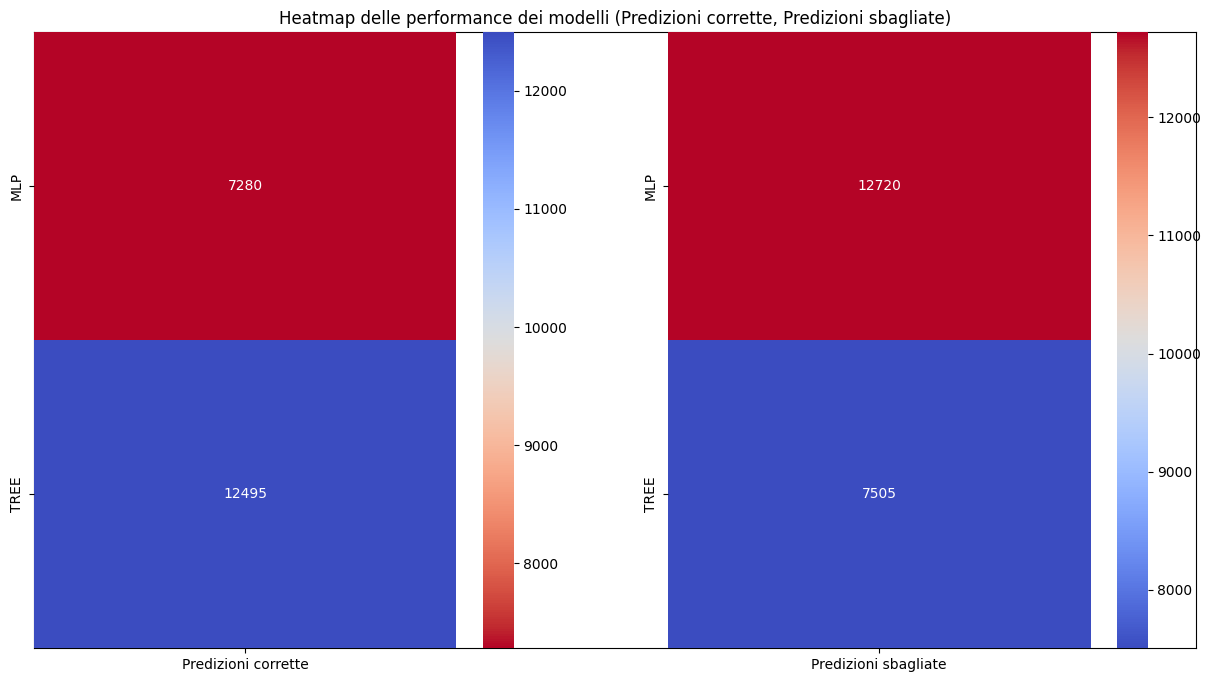

In [12]:
# Definizione funzione per calcolo dell'errore delle predizioni
def calculate_error_prediction(model, X, y):
    rounded_predictions = np.round(model.predict(X).reshape(-1)).astype(int)
    boolean_array_result = y.numpy() == rounded_predictions
    count_elements = np.unique(boolean_array_result, return_counts=True)
    count_elements = dict(np.transpose(count_elements))

    return {'Predizioni sbagliate': count_elements[0], 'Predizioni corrette': count_elements[1]}

# Inizializzazione del dizionario delle performance
performance = {'Predizioni sbagliate': [], 'Predizioni corrette': []}

for model in elenco_modelli.values():
    # Calcolo delle metriche di errore per il modello corrente
    result_predictions = calculate_error_prediction(model, x_test, y_test)

    # Aggiunta delle metriche al dizionario delle performance
    for name, result in result_predictions.items():
        performance[name].append(result)

# Creazione di un DataFrame con le performance dei modelli
df_ = pd.DataFrame(performance, index=elenco_modelli.keys())
df_err = pd.DataFrame(df_.iloc[:,0])
df_corr = pd.DataFrame(df_.iloc[:,1])

# Visualizzazione della heatmap
plt.figure(figsize=(15, 8))
plt.yticks([])
plt.xticks([])
plt.title("Heatmap delle performance dei modelli (Predizioni corrette, Predizioni sbagliate)")
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, cmap='coolwarm_r', fmt='d')
plt.subplot(1, 2, 2)
sns.heatmap(df_err, annot=True, cmap='coolwarm', fmt='d')
plt.show()

L'analisi delle predizioni conferma il confronto tra le metriche visto poc'anzi.

## Confronto tra l'apprendimento dei modelli

📈 Effettuiamo ora un confronto tra i **modelli di apprendimento automatico** e vediamo in che modo le metriche che stiamo monitorando vengono ottimizzate al passare delle epoche di addestramento.

In questo confronto non includiamo i modelli di Machine Learning tradizionale in quanto il loro apprendimento non si basa sulle epoche e perciò sarebbe impossibile visualizzare la comparazione del processo di apprendimento.

Visualizziamo dunque tutte le metriche di errore, di cui ci aspettiamo una discesa e il $R^2$ score di cui invece ci aspettiamo un  incremento con il raffinamento del modello.

Abbiamo deciso di visualizzare i grafici utilizzando una **scala logaritmica** sull'asse verticale, questa infatti ci permette di evidenziare al meglio le **fluttuazioni** delle metriche, dunque di farci un'idea grafica circa la stabilità dei modelli.

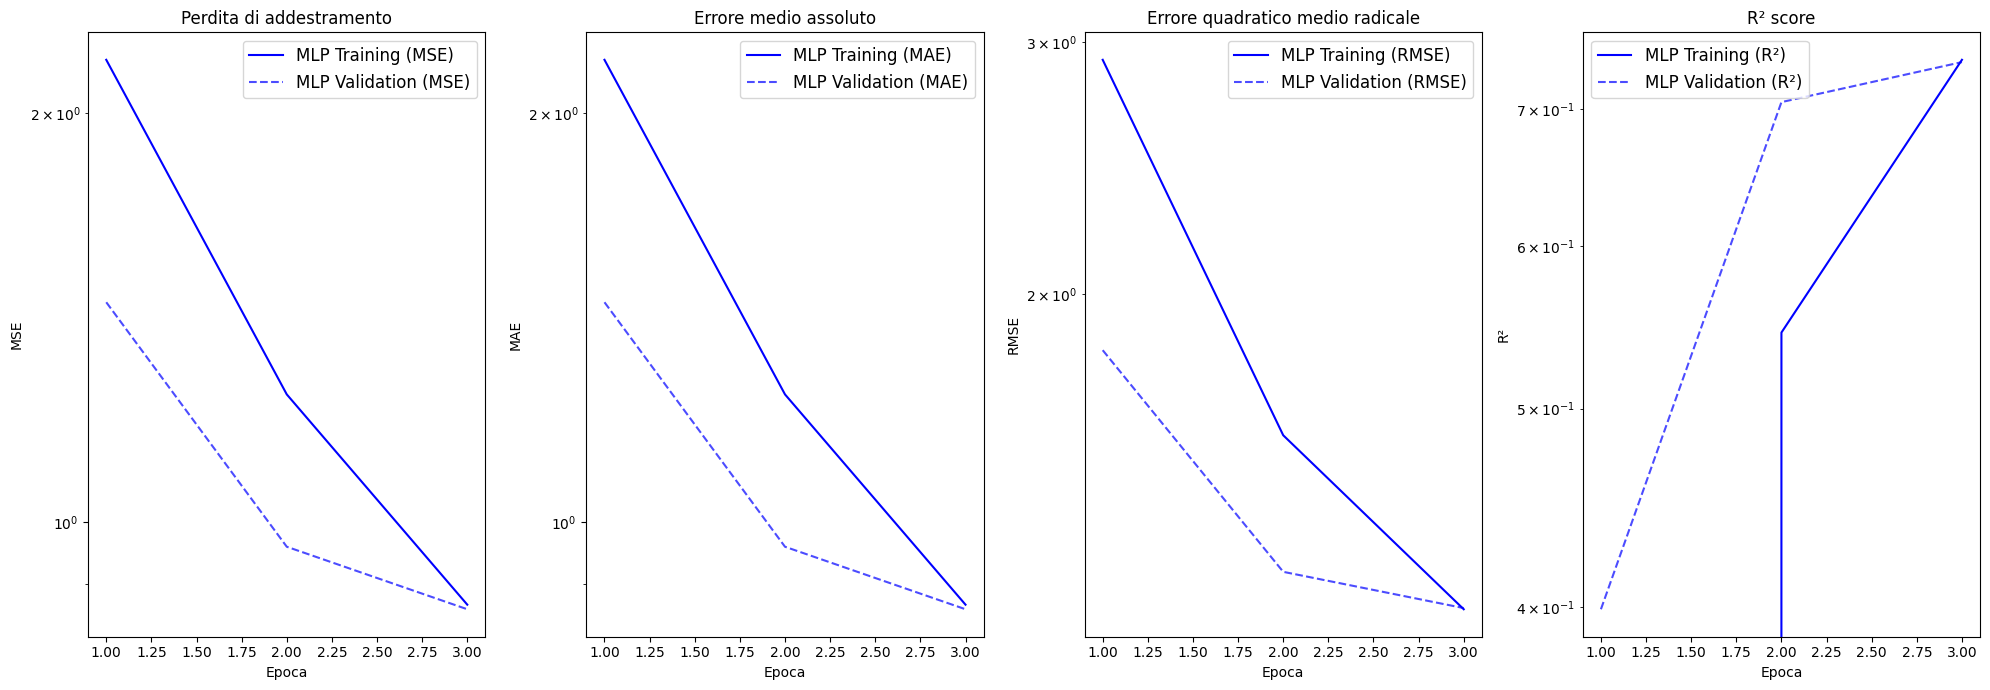

In [13]:
# Definizione funzione di creazione linechart
def plot_data(ax, epochs, metric, val_metric, model_name, metric_name, color):
    ax.plot(epochs, metric, color, label=f'{model_name} Training ({metric_name})') 
    ax.plot(epochs, val_metric, color+'--', alpha=0.7, label=f'{model_name} Validation ({metric_name})') 
    ax.set_xlabel('Epoca')
    ax.legend(fontsize='large')

plt.figure(figsize=(20, 7))


# Crea subplot per ogni metrica
ax1 = plt.subplot(1, 4, 1)
ax1.set_title('Perdita di addestramento')
ax1.set_ylabel('MSE')
ax1.set_yscale('log')

ax2 = plt.subplot(1, 4, 2)
ax2.set_title('Errore medio assoluto')
ax2.set_ylabel('MAE')
ax2.set_yscale('log')

ax3 = plt.subplot(1, 4, 3)
ax3.set_title('Errore quadratico medio radicale')
ax3.set_ylabel('RMSE')
ax3.set_yscale('log')

ax4 = plt.subplot(1, 4, 4)
ax4.set_title('R² score')
ax4.set_ylabel('R²')
ax4.set_yscale('log')

# Per ogni modello associato al suo colore
for (model_name, history), color in zip(histories.items(), COLORS):

    # Salvataggio performance
    loss, val_loss, mae, val_mae, rmse, val_rmse, r2_score, val_r2_score = history['loss'], history['val_loss'], history['mae'], history['val_mae'], history['rmse'], history['val_rmse'], history['r2_score'], history['val_r2_score']

    # Calcolo numero di epoche 
    epochs = range(1, len(loss) + 1)

    # Creazione 3 plot con performance di train e validation al variare delle epoche
    plot_data(ax1, epochs, loss, val_loss, model_name, 'MSE', color)
    plot_data(ax2, epochs, mae, val_mae, model_name, 'MAE', color)
    plot_data(ax3, epochs, rmse, val_rmse, model_name, 'RMSE', color)
    plot_data(ax4, epochs, r2_score, val_r2_score, model_name, 'R²', color)

plt.tight_layout()
plt.show()


Dai grafici possiamo notare come i modelli con livelli _DenseKAN_ abbiano, per le metriche di validazione, prestazioni migliori dell'architettura MLP classica, inoltre questi modelli riescono a ottimizzare le metriche in molte meno epoche.

È possibile notare come il modello KAN-MLP riesca a tenere una minore differenza tra le metriche di addestramento e quelle di validazione, mentre questa è più evidente nel modello MLP.


## Analisi dell'equità di genere

👫Dopo aver valutato i nostri modelli dal punto di vista prestazionale, ora considereremo l'aspetto dell'**equità algoritmica**.

Confrontiamo i modelli sulle solite metriche, questa volta distinguendo i record in base all'attributo **gender** (che nel nostro caso assume due valori). 

Non trattandosi di un task di classificazione definire una **matrice di confusione** risulta problematico perché in questo contesto risultano privi di significato i concetti di vero positivo, vero negativo, falso positivo e falso negativo. Per valutare l'equità abbiamo deciso dunque di basarci sulle metriche già utilizzate per il confronto prestazionale e osservare in che modo queste variano al variare dell'attributo di genere.

Anche in questo caso presenteremo un confronto sul numero di predizioni corrette ed errate dei vari modelli, ma questa volta coglieremo la variabilità rispetto all'attributo sensibile di nostro interesse.

I modelli più equi avranno prestazioni simili per entrambe le categorie considerate.

359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


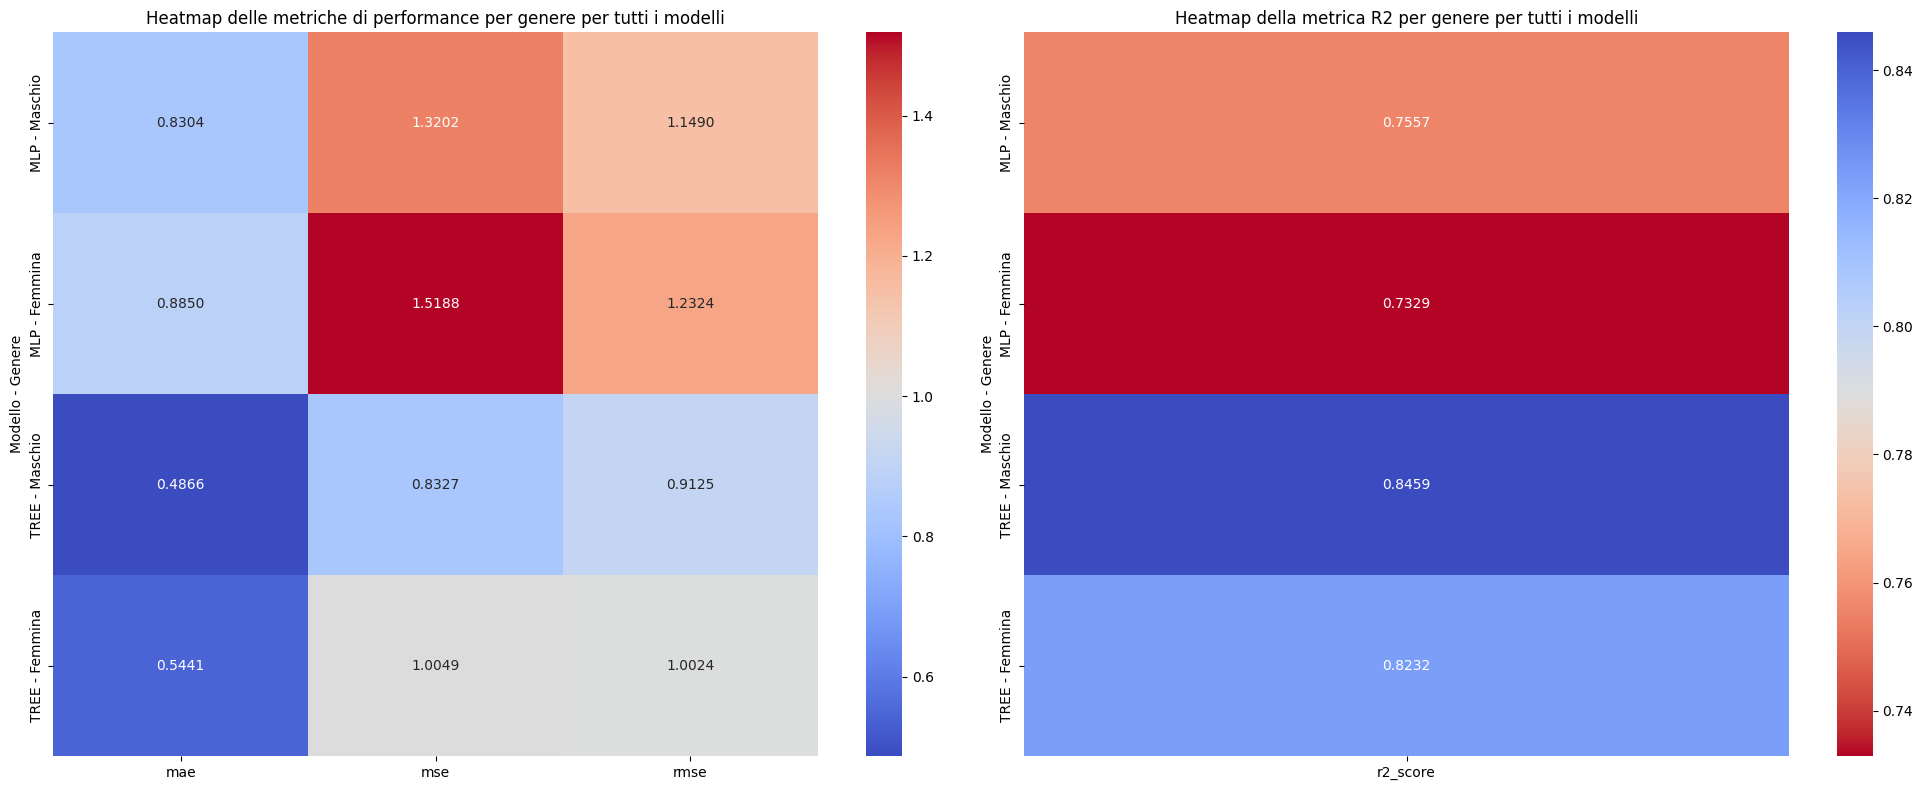

In [14]:
# Definizione delle categorie e sottogruppi
CATEGORY = 'gender'
INDEX_CATEGORY = FEATURES.index(CATEGORY)
SUBGROUPS = df[CATEGORY].unique()
SUBGROUP_NAMES = ['Maschio', 'Femmina']  # Aggiungiamo questa riga per i nomi leggibili

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

for model_name, model in elenco_modelli.items():
    results = {}

    for sg, sg_name in zip(SUBGROUPS, SUBGROUP_NAMES):
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, INDEX_CATEGORY] == sg
        features1 = x_test[subgroup_indices]
        labels = y_test[subgroup_indices]
        
        # Calcolo delle metriche per ciascun sottogruppo
        results[sg_name] = calculate_metrics(model, features1, labels)

    all_results[model_name] = results

# Creazione Dataframe performance per tutte le metriche tranne R2
df_metrics = pd.DataFrame()

# Creazione Dataframe performance per R2
df_r2 = pd.DataFrame()

for model_name, results in all_results.items():
    # Definizione dataframe di un modello per tutte le metriche tranne R2
    temp_df_metrics = pd.DataFrame({sg: [result[metric] for metric in METRICS_NAME.values() if metric != 'r2_score'] 
                                    for sg, result in results.items()}, 
                                   index=[metric for metric in METRICS_NAME.values() if metric != 'r2_score'])
    temp_df_metrics.columns = [f'{model_name} - {sg}' for sg in SUBGROUP_NAMES]

    # Definizione dataframe di un modello per R2
    temp_df_r2 = pd.DataFrame({sg: [result['r2_score']] for sg, result in results.items()}, 
                              index=['r2_score'])
    temp_df_r2.columns = [f'{model_name} - {sg}' for sg in SUBGROUP_NAMES]

    # Concatenazione dataframe di un modello ai precedenti
    df_metrics = pd.concat([df_metrics, temp_df_metrics], axis=1)
    df_r2 = pd.concat([df_r2, temp_df_r2], axis=1)

# Processamento dei dataset
df_metrics = df_metrics.astype(float).transpose()
df_r2 = df_r2.astype(float).transpose()

# Visualizzazione delle heatmaps
plt.figure(figsize=(20, 8))

# Heatmap per tutte le metriche tranne R2
plt.subplot(1, 2, 1)
sns.heatmap(df_metrics, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.ylabel('Modello - Genere')

# Heatmap per R2
plt.subplot(1, 2, 2)
sns.heatmap(df_r2, annot=True, cmap='coolwarm_r', fmt=".4f")
plt.title('Heatmap della metrica R2 per genere per tutti i modelli')
plt.ylabel('Modello - Genere')

plt.tight_layout()
plt.show()

Per comprendere questa visualizzazione, consideriamo che i modelli più equi sono quelli per cui le metriche rimangono simili al variare dell'attributo **gender** (ci aspettiamo quindi che, osservando le metriche di una stessa rete, queste non siano significativamente diverse, sotto l'ipotesi che la rete sia equa).

Anche in questo caso notiamo come i modelli di apprendimento automatico siano nettamente superiori rispetto a quelli tradizionali; nel confronto dei primi possiamo vedere come, ancora una volta la rete MLP rimanga leggermente indietro rispetto a KAN e KAN-MLP, in quanto la differenza di tonalità di colore tra le sue due righe adiacenti è più marcata.

# Trasparenza algoritmica
🪟Tra gli obiettivi principali del nostro progetto c'è quello di valutare se e in che misura le KAN possano introdurre dei miglioramenti nella **trasparenza algoritmica**.

Si tratta di un aspetto fondamentale in particolare su applicazioni che utilizzano dati sensibili come la nostra, per le quali non sarebbero accettabili elaborazioni di tipo black-box.

Per studiare la spiegabilità abbiamo utilizzato tre metodi:

- Feature importance
- LIME (Local Interpretable Model-agnostic Explanations)
- Grafo di rappresentazione dei livelli

I primi due sono **agnostici** cioè applicabili a qualsiasi modello, il terzo è invece specifico per l'architettura delle KAN.

## Feature importance

📊Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.


Ad esempio, supponiamo di dover acquistare una nuova casa vicino al posto di lavoro. Quando si acquista una casa, si pensa a diversi fattori. Il fattore più importante nel processo decisionale potrebbe essere l’ubicazione della proprietà, quindi probabilmente si cercheranno solo case vicine al posto in questione. Feature importance funziona in modo simile. Classificherà le caratteristiche in base all’effetto che hanno sulla previsione del modello.

Feature importance è importante per le seguenti ragioni:

1. **Data Comprehension**:
Aiuta anche a capire quali caratteristiche sono irrilevanti per il modello e quali invece sono importanti.

2. **Model Improvement**:
Durante l'addestramento del modello, è possibile utilizzare i punteggi calcolati in base all'importanza delle funzionalità per ridurre la dimensionalità del modello. Le caratteristiche con punteggi più alti vengono solitamente mantenute e quelle con punteggi più bassi vengono cancellate poiché non sono importanti per il modello. Ciò semplifica il modello e accelera il funzionamento del modello, migliorando in definitiva le prestazioni del modello.

3. **Model Interpretability**:
L'importanza delle funzionalità è utile anche per interpretare e comunicare il modello ad altre parti interessate. Calcolando i punteggi per ciascuna funzionalità, si puo determinare quali funzionalità attribuiscono maggiormente il potere predittivo al modello.

In [27]:
# Calcola feature importance del modello
def calculate_feature_importance(model, X, y):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
        importance = results.importances_mean

    # Ritorna un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(FEATURES, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per ogni modello
caratteristiche = []
for nome, modello in elenco_modelli.items():
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

Stampiamo i risultati ottenuti dal metodo feature importance sotto forma di testo in forma normalizzata e non, la forma normalizzata aiuta a confrontare l'importanza di una caratteristica rispetto ad un'altra quindi la useremo anche nella creazione del grafico poco sotto.

In [ ]:
importanze = {}

for nome_modello, importanza_caratteristiche in caratteristiche:
    importanze[nome_modello] = {}

    # Stampa il nome del modello
    print(f"\nModello: {nome_modello}")
    
    # Calcola totale delle importanze
    totale = sum(abs(imp) for imp in importanza_caratteristiche.values())
    
    # Stampa le caratteristice e la loro importanza normalizzata
    for caratteristica, importanza in importanza_caratteristiche.items():
        importanze[nome_modello][caratteristica] = importanza / totale
        print(f"Caratteristica: {caratteristica}, Importanza: {importanza:.2f}, Importanza nortmalizzata: {((importanza / totale)):.2f}")
        


Modello: KAN
Caratteristica: vdate, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: rcount, Importanza: 6.41, Importanza nortmalizzata: 0.69
Caratteristica: gender, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: dialysis, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: asthma, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: irondef, Importanza: 0.21, Importanza nortmalizzata: 0.02
Caratteristica: pneum, Importanza: 0.08, Importanza nortmalizzata: 0.01
Caratteristica: subdep, Importanza: 0.19, Importanza nortmalizzata: 0.02
Caratteristica: psychmaj, Importanza: 0.70, Importanza nortmalizzata: 0.07
Caratteristica: depress, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: psychother, Importanza: 0.12, Importanza nortmalizzata: 0.01
Caratteristica: fibrosis, Importanza: 0.01, Importanza nortmalizzata: 0.00
Caratteristica: malnutr, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: hemo, Impo

Visualizziamo ora graficamente i risultati di Feature importance: qui la visualizzazione più appropriata è sicuramente il barchart multiplo perche permette di rappresentare l'importanza dei singoli attributi per ogni modello in forma intuitiva.

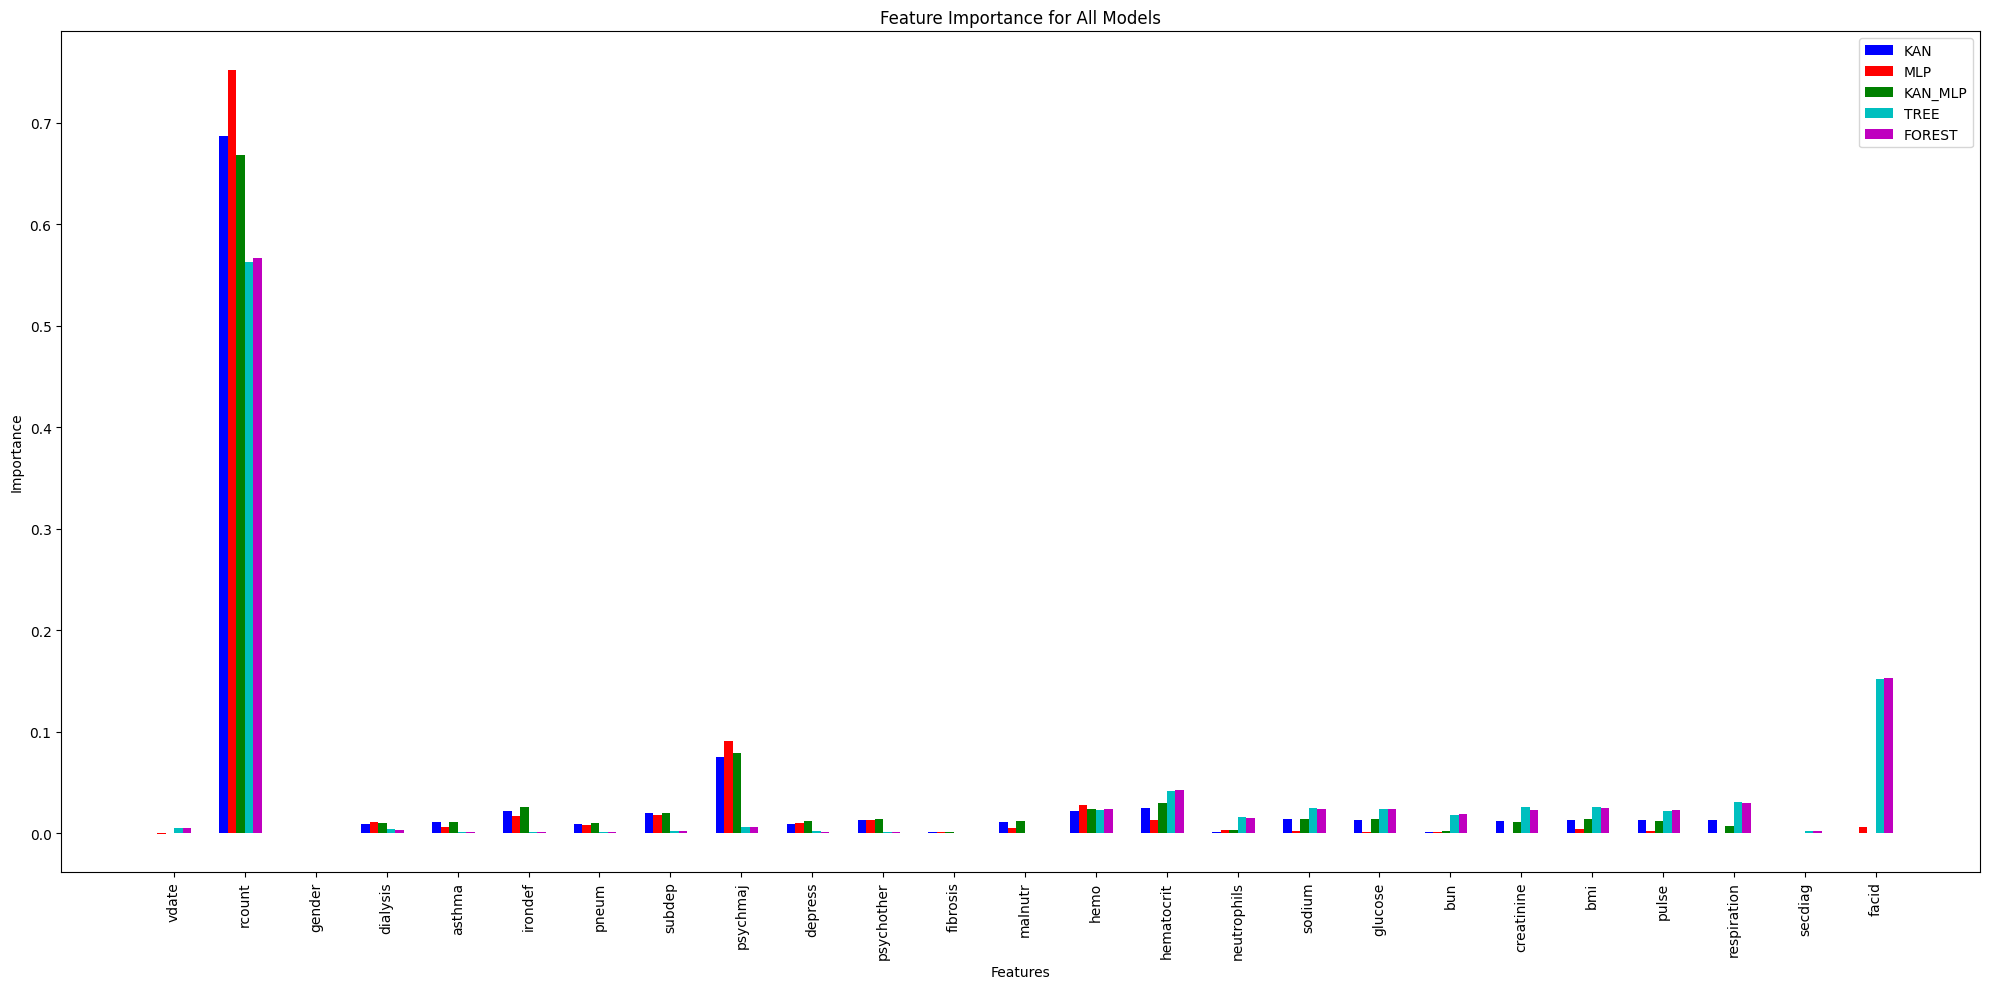

In [ ]:
# Crea i ticks per l'asse x
xticks = np.arange(N_FEATURES)

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))

# Calcola la larghezza delle barre in base al numero di modelli
BAR_WIDTH = 0.6
bar_width = BAR_WIDTH / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello di un certo colore
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(xticks - BAR_WIDTH/2 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=COLORS[i % len(COLORS)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(xticks)
ax.set_xticklabels(FEATURES, rotation=90)
ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

Si nota subito come tutti i modelli utilizzino l'attributo **rcount** in maniera determinante, in particolare l'ensemble, mentre gli altri attributi hanno un'importanza comparativamente molto minore.

Quest'ultimo fatto sembrebbe controintuitivo, in quanto ci si aspetterebbe che i modelli utilizzino maggiormente gli attributi riferiti alle rilevazioni mediche.

L'importanza dell'attributo **rcount** si poteva già intravedere con la visualizzazione dell'albero decisionale, il quale utilizzava il suddetto attributo per diversi split iniziali.

## LIME

🍋‍🟩 Il metodo **LIME** (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le predizioni di modelli complessi **su singole istanze** tramite modelli interpretabili e locali.  

Quindi si concentra nella spiegazione di singole predizioni piuttosto che su modelli globali. Cerca di rispondere alla domanda: “_Perché il modello ha fatto questa specifica previsione per un dato input_?”

**LIME** perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, costruisce un modello interpretabile (ad esempio, un regressore lineare) con cui effettua le predizioni sui record nell'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni mediante l'approssimazione con un modello più semplice.

Valore reale: 3.0
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


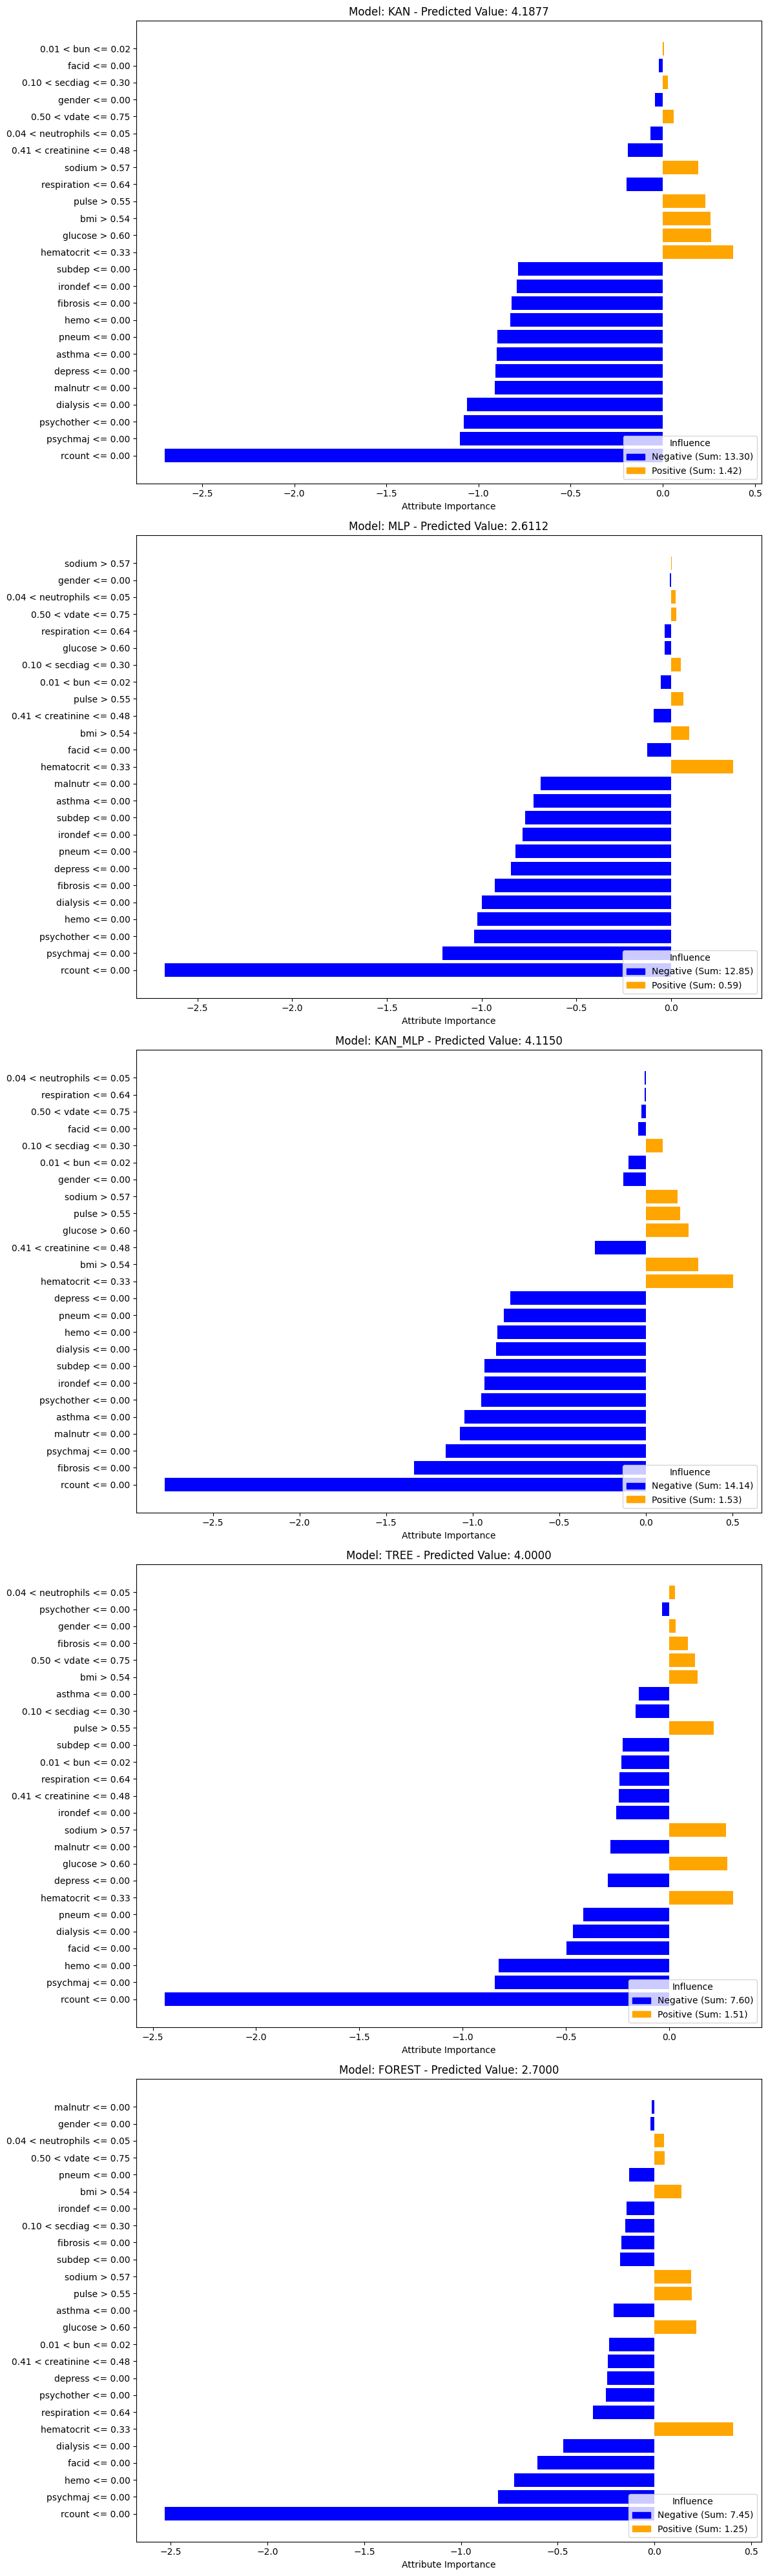

In [ ]:
# Conversione di x_train e x_test in array numpy
X_train_np = x_train.numpy()
X_test_np = x_test.numpy()

# Creazione di un oggetto LimeTabularExplainer
explainer = LimeTabularExplainer(
    X_train_np,
    feature_names=FEATURES,
    class_names=['target'],
    mode='regression'
)

# Creazione di una figura con un subplot per ogni modello
fig, axs = plt.subplots(len(elenco_modelli), 1, figsize=(12, 8*len(elenco_modelli)), squeeze=False)

# Seleziona un'istanza casuale
index_selected = random.randint(0, len(X_test_np)-1)
instance = X_test_np[index_selected]
print(f"Valore reale: {y_test[index_selected].numpy()}")

# Per ogni modello dell'istanza selezionata con LIME
for i, (model_name, model) in enumerate(elenco_modelli.items()):

    explanation = explainer.explain_instance(
        instance, 
        lambda x: model.predict(tf.convert_to_tensor(x.reshape(-1, x_train.shape[1]))),
        num_features=N_FEATURES
    )
    
    # Estrazione degli attributi e delle importanze
    attributi, importances = zip(*explanation.as_list())

    colors = ['blue' if imp < 0 else 'orange' for imp in importances]
    
    # Creazione di un barplot per le importanze
    ax = axs[i, 0]
    ax.barh(range(N_FEATURES), importances, color=colors)
    ax.set_yticks(range(N_FEATURES))
    ax.set_yticklabels(attributi)
    ax.set_xlabel('Attribute Importance')
    
    # Calcolo della previsione del modello sull'istanza selezionata
    predicted_value = model.predict(tf.convert_to_tensor(instance.reshape(1, -1)))

    predicted_value_str = ', '.join(f'{v:.4f}' for v in np.atleast_1d(predicted_value.flatten()))
    
    # Impostazione del titolo del subplot
    ax.set_title(f'Model: {model_name} - Predicted Value: {predicted_value_str}')
    ax.set_facecolor('white')
    
    # Calcolo della somma delle importanze positive e negative
    positive_sum = sum(imp for imp in importances if imp > 0)
    negative_sum = abs(sum(imp for imp in importances if imp < 0))
    
    # Aggiunta di una leggenda con le somme delle importanze
    ax.legend(
        [plt.Rectangle((0,0),1,1, color=c) for c in ['blue', 'orange']],
        [f'Negative (Sum: {negative_sum:.2f})', f'Positive (Sum: {positive_sum:.2f})'],
        title='Influence', loc='lower right'
    )

# Visualizzazione del grafico
plt.tight_layout()
plt.show()

Questi risultati vanno interpretati notando che:

- Quanto più è maggiore la somma dei valori riferiti agli attributi che influiscono positivamente, tanto più il valore della predizione aumenta in termini numerici;

- Quanto più è minore la somma dei valori riferiti agli attributi che influiscono negativamente, tanto più il valore della predizione diminuisce in termini numerici;

Dunque il valore finale della predizione viene spiegato in termini di contribuzioni positive e negative di ognuno degli attributi.

Possiamo notare come generalmente la somma dei contributi negativi sia maggiore della somma di quelli positivi.

## Grafo di Architettura della KAN

🕸️Questo approccio, già utilizzato dagli autori dell'articolo introduttivo alle KAN, permette di visualizzare i grafici delle funzioni spline ai *nodi* della rete.

Si ricorda che al nodo $n$ della rete corrisponde la funzione $$l_n = \sum_{i_{0}=1}^{units_{l-1}}{\phi_{n,i_0}}$$

Noi tuttavia abbiamo seguito un approccio alternativo: mentre nel paper vengono rappresentate le spline su ogni singolo arco dell'architettura, abbiamo deciso di aggregare le spline entranti in ogni nodo sommandone i grafici e ottenendo quindi un grafico per ogni nodo e non uno per ogni arco.

Questa scelta è stata effettuata perché al contrario delle reti costruite nel paper, che avevano un numero molto contenuto di nodi nei livelli nascosti, vista la maggior semplicita dei task e dei dataset a cui erano destinati, le nostre reti presentano dimensioni ben piu elevate, per cui una rappresentazione esaustiva appesantirebbe notevolmente il carico cognitivo necessario per comprendere la visualizzazione; 

Si pensi che, essendo il numero di spline di un livello $l$ dato da $$\#splines_l = inputs_l * units_l$$

💣 Le splines da visualizzare per il solo primo livello della rete sarebbero state ben $25*16=400$ !

In definitiva abbiamo optato per un compromesso tra spiegabilità ed efficienza della visualizzazione, se infatti l'approccio originale permetterebbe di osservare tutte le spline che vengono composte per determinare il risultato finale offrendo una spiegabilità molto soddisfacente, questa sarebbe compromessa dal carico cognitivo necessario per interpretarle, oltre alla scarsità della spazio a disposizione per rappresentarle.

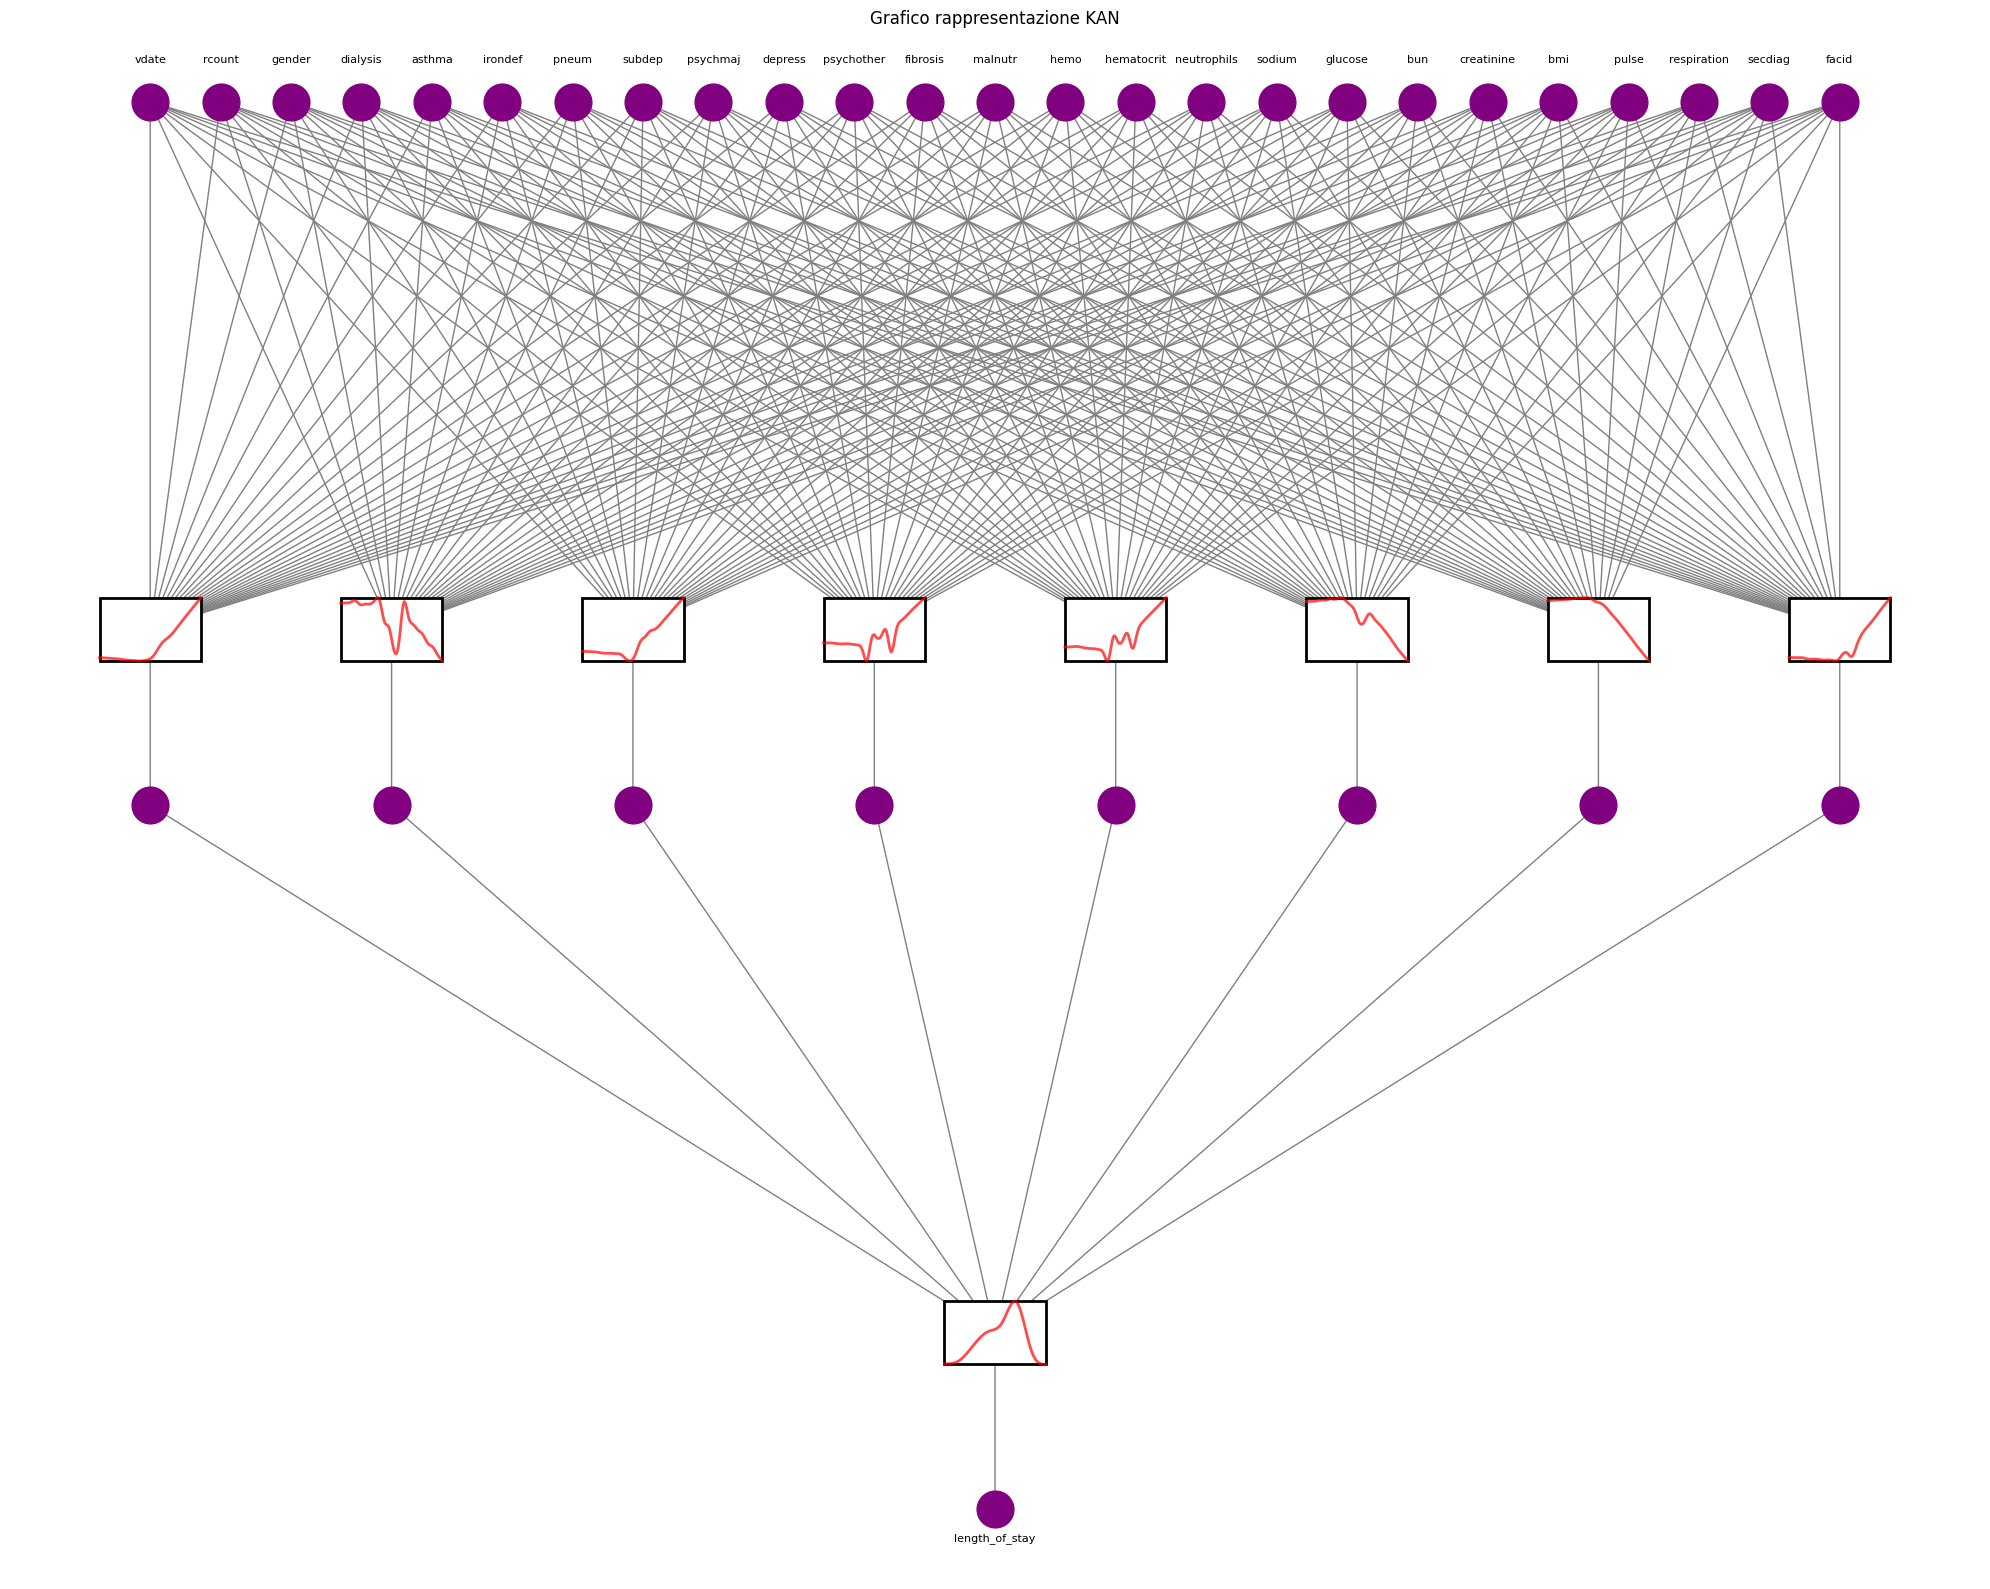

In [ ]:
# Definizione della funzione 'get_all_splines_from_model' che estrae tutte le spline da un modello
def get_all_splines_from_model(model):
    all_splines = []

    # Estrae splines di ogni KAN
    for layer in model.layers:
        if isinstance(layer, DenseKAN):
            splines = layer.get_spline_list()
            all_splines.append(splines)
            
    return all_splines

# Definizione della funzione 'create_kan_tree_from_model' che crea un grafo da un modello
def create_kan_tree_from_model(model, features):
    # Creazione di un grafo diretto
    G = nx.DiGraph()
    
    # Aggiunta dei nodi di input al grafo
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiunta dei layer nascosti e di output al grafo
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")

    return G

# Definizione della funzione 'draw_merged_edges' che disegna gli archi e le spline nel grafo
def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    # Inizializzazione di una lista vuota per contenere i punti di fusione
    merge_points = []
    # Per ogni nodo nel grafo
    for target in G.nodes():
        # Ottiene la lista degli archi entranti nel nodo
        in_edges = list(G.in_edges(target))
        # Se ci sono più di un arco entrante
        if len(in_edges) > 1:
            # Calcola la posizione del punto di fusione
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            # Aggiunge il punto di fusione alla lista dei punti di fusione
            merge_points.append(merge_point)
            
            # Per ogni arco entrante
            for source, _ in in_edges:
                # Calcola la posizione di partenza dell'arco
                start = np.array(pos[source])
                # Disegna l'arco dal punto di partenza al punto di fusione
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            # Disegna un arco dal punto di fusione al nodo
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    # Ottiene tutte le spline dal modello
    spline_collection = get_all_splines_from_model(kan)
    sum_of_spline = []
    knots_list = []

    # Prende le liste delle spline di cui fare la somma
    for spline_model in spline_collection:
        for i in range(len(spline_model[0])):
            knots_list.append(spline_model[0][0].t)
            list_splines = [spline_model[j][i] for j in range(len(spline_model))]
            sum_of_spline.append(list_splines)

    square_size = 0.06  # Dimensione fissa del quadrato
    # Per ogni punto di fusione
    for i, point in enumerate(merge_points):
        # Se c'è una spline corrispondente al punto di fusione
        if i < len(sum_of_spline):
            # Disegna un rettagolo attorno al punto di fusione
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Calcola la somma delle spline entranti in un nodo
            spl = sum_of_spline[i]
            xx = np.linspace(knots_list[i][0, 0], knots_list[i][0, -1], 100) 
            yy = 0
            for s in spl:
                yy += s(xx)
            
            # Normalizza i valori della spline per adattarsi al quadrato
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            # Disegna la spline normalizzata
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    return merge_points


# Crea un grafo dal modello
G = create_kan_tree_from_model(kan, FEATURES)

# Imposta il grafico
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Disegna gli archi e i quadrati con le spline nel grafo
merge_points = draw_merged_edges(G, pos, ax, kan)

# Disegna i nodi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Imposta l'ordine di sovrapposizione per i nodi

# Aggiunge le etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Aggiunge l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

# Imposta il titolo del grafico
plt.title("Grafico rappresentazione KAN")
# Nasconde gli assi
plt.axis('off')
# Ridimensiona il layout del grafico
plt.tight_layout()
# Mostra il grafico
plt.show()

Come detto in precedenza, questo grafo non permette una comprensione accurata e puntuale di quanto sta avvenendo a livello delle spline.

In ogni caso, qualora una specifica applicazione dovesse consentire di visualizzare agevolmente tutte le splines sugli archi, l'interpretazione dei risultati dovrebbe comunque essere lasciata agli esperti del settore in quanto richiederebbe una profonda comprensione del significato dei dati, soprattutto riguardo quelli di carattere medico.